[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Space-Dream-42/brainTumourProject/blob/main/Code/First_Model_UNet.ipynb)

## First approach: UNet  

In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.datasets.vision import StandardTransform
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.optim import Adam

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline 
import json
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import SimpleITK as sitk

from Dataset_Utils import BraTS_TrainingDataset
from Dataset_Utils import BraTS_TestDataset
from Dataset_Utils import plot_batch

from unet_short import UNet
from mateusbuda_utils import dsc, dsc_per_volume
from mateusbuda_loss import DiceLoss

In [2]:
torch.manual_seed(0)

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

## Data loading setup

In [5]:
# PATH
dataset_path = '../Task01_BrainTumour/cropped_small'

train_data = BraTS_TrainingDataset(dataset_path, 30, 42)
test_data = BraTS_TestDataset(dataset_path, 30, 42)

../Task01_BrainTumour/cropped_small\imagesTr
../Task01_BrainTumour/cropped_small\labelsTr
../Task01_BrainTumour/cropped_small\imagesTr
../Task01_BrainTumour/cropped_small\labelsTr


In [6]:
trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=1, shuffle=True)

testloader = torch.utils.data.DataLoader(
    test_data, batch_size=1, shuffle=True)

train_iter = iter(trainloader)
test_iter = iter(testloader)

sample_batch = train_iter.next()
print(sample_batch['image'].shape)
print(sample_batch['label'].shape)

torch.Size([1, 4, 155, 191, 161])
torch.Size([1, 1, 155, 191, 161])


In [ ]:
sample_batch = test_iter.next()
# plot_batch(sample_batch, num_rows=2, height=75)

## Create the model

In [ ]:
# predefined models:
# https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
# https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb

# unet implementation
# https://github.com/milesial/Pytorch-UNet

In [ ]:
device = 'cuda:0'
loaders = {"train": trainloader, "valid": testloader}
unet = UNet(in_channels=4, out_channels=1, init_features=4)
unet.to(device)
dsc_loss = DiceLoss()
best_validation_dsc = 0.0
optimizer = optim.Adam(unet.parameters(), lr=0.0001)
loss_train = []
loss_valid = []

step = 0


for epoch in range(3):
        for phase in ["train", "valid"]:
            if phase == "train":
                unet.train()
            else:
                unet.eval()

            validation_pred = []
            validation_true = []

            for i, data in enumerate(loaders[phase]):
                if phase == "train":
                    step += 1
                
                x = data['image']
                y_true = data['label']
                x, y_true = x.to(device), y_true.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    y_pred = unet(x)
                    loss = dsc_loss(y_pred, y_true)

                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()                

In [ ]:
batch_slices = sample_batch['image']
batch_slices = batch_slices.to(device)
output = unet(batch_slices)
output_array = torch.round(output[0][:,70,:,:]).detach().cpu().numpy()
output_array[0].shape

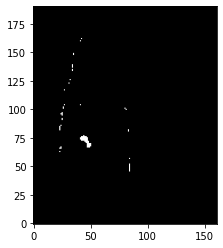

In [11]:
plt.imshow(output_array[0], cmap="gray", origin="lower")

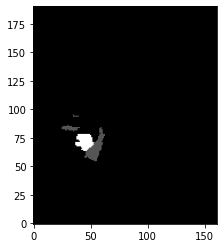

In [12]:
plt.imshow(sample_batch['label'][0][0,70,:,:], cmap="gray", origin="lower")

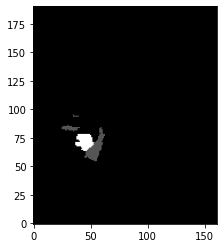

In [13]:
plt.imshow(sample_batch['label'][0][0,70,:,:], cmap="gray", origin="lower")